In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Используем предобученную сеть

## A Semantic Segmentation Network for Urban-Scale Building Footprint Extraction Using RGB Satellite Imagery

This repository is the official implementation of **[A Semantic Segmentation Network for Urban-Scale Building Footprint Extraction Using RGB Satellite Imagery](https://arxiv.org/abs/2104.01263)** by Aatif Jiwani, Shubhrakanti Ganguly, Chao Ding, Nan Zhou, and David Chan. 

![model visualization](./imgs/visual.jpg "Title")

### Requirements

1. To install GDAL/`georaster`, please follow this [doc](https://mothergeo-py.readthedocs.io/en/latest/development/how-to/gdal-ubuntu-pkg.html) for instructions. 
2. Install other dependencies from requirements.txt
```setup
pip install -r requirements.txt
```

### Datasets

#### Downloading the Datasets
1. To download the AICrowd dataset, please go [here](https://www.aicrowd.com/challenges/mapping-challenge-old). You will have to either create an account or sign in to access the training and validation set. Please store the training/validation set inside `<root>/AICrowd/<train | val>` for ease of conversion.
2. To download the Urban3D dataset, please run:
```setup
aws s3 cp --recursive s3://spacenet-dataset/Hosted-Datasets/Urban_3D_Challenge/01-Provisional_Train/ <root>/Urban3D/train
aws s3 cp --recursive s3://spacenet-dataset/Hosted-Datasets/Urban_3D_Challenge/02-Provisional_Test/ <root>/Urban3D/test
``` 
3. To download the SpaceNet Vegas dataset, please run:
```setup
aws s3 cp s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/SN2_buildings_train_AOI_2_Vegas.tar.gz <root>/SpaceNet/Vegas/
aws s3 cp s3://spacenet-dataset/spacenet/SN2_buildings/tarballs/AOI_2_Vegas_Test_public.tar.gz <root>/SpaceNet/Vegas/

tar xvf <root>/SpaceNet/Vegas/SN2_buildings_train_AOI_2_Vegas.tar.gz
tar xvf <root>/SpaceNet/Vegas/AOI_2_Vegas_Test_public.tar.gz
```

#### Converting the Datasets

Please use our provided dataset converters to process the datasets. For all converters, please look at the individual files for an example of how to use them. 
1. For AICrowd, use `datasets/converters/cocoAnnotationToMask.py`. 
2. For Urban3D, use `datasets/converters/urban3dDataConverter.py`.
3. For SpaceNet, use `datasets/converters/spaceNetDataConverter.py`

#### Creating the Boundary Weight Maps

In order to train with the exponentially weighted boundary loss, you will need to create the weight maps as a pre-processing step. Please use `datasets/converters/weighted_boundary_processor.py` and follow the example usage. The `inc` parameter is specified for computational reasons. Please decrease this value if you notice very high memory usage. 

**Note:** these maps are not required for evaluation / testing. 

### Pre-Trained Weights

We provide pre-trained model weights in the `weights/` directory. Please use Git LFS (git lfs pull) to download these weights. These weights correspond to our best model on all three datasets.


### Training and Evaluation
To train / evaluate the DeepLabV3+ models described in the paper, please use `train_deeplab.sh` or `test_deeplab.sh` for your convenience. We employ the following primary command-line arguments:

| Parameter                 | Default       | Description (final argument)  |	
| :------------------------ |:-------------:| :-------------|
| --backbone 	    |	`resnet`         | The DeeplabV3+ backbone **(final method used `drn_c42`)**
| --out-stride | 16 | The backbone compression facter **(8)**
| --dataset | `urban3d` | The dataset to train / evaluate on (other choices: `spaceNet`, `crowdAI`, `combined`)
| --data-root | `/data/` | **Please replace this with the root folder of the dataset samples**
| --workers | 2 | Number of workers for dataset retrieval
| --loss-type | `ce_dice` | Type of objective function. Use `wce_dice` for exponentially weighted boundary loss
| --fbeta | 1 | The beta value to use with the F-Beta Measure  **(0.5)**
| --dropout | `0.1 0.5` | Dropout values to use in the DeepLabV3+ **(0.3 0.5)**
|--epochs | None | Number of epochs to train **(60 for train, 1 for test)**
| --batch-size| None | Batch size **(3/4)**
| --test-batch-size| None | Testing Batch Size **(1/4)**
| --lr | `1e-4` | Learning Rate **(`1e-3`)**
| --weight-decay | `5e-4` | L2 Regularization Constant **(`1e-4`)**
| --gpu-ids | `0` | GPU Ids (Use `--no-cuda` for only CPU)
| --checkname | None | Experiment name
| --use-wandb | False | Track experiment using WandB
| --resume | None | Experiment name to load weights from (i.e. `urban` for `weights/urban/checkpoint.pth.tar`)
| --evalulate | False | **Enable this flag for testing**
| --best-miou | False | **Enable this flag to get best results when testing**
| --incl-bounds | False | **Enable this flag when training with `wce_dice` as a loss**

To train with the cross-task training strategy, you need to:
1. Train a model using `--dataset=combined` until the best loss has been achieved
2. Train a model using `--resume=<checkname>` on one of the three primary datasets until the best mIoU is achieved 

### Results

Our final model is a **DeepLavV3+ module with a Dilated ResNet C42 backbone** trained using the F-Beta Measure + Exponentially Weighted Cross Entropy Loss **(Beta = 0.5)**. We employ the cross-task training strategy only for **Urban3D and SpaceNet**. 

Our model achieves the following:

| Dataset | Avg. Precision  | Avg. Recall | F1 Score | mIoU | 
| ----------- |---------------- | -------------- | ------- | ------- |
| Urban3D   |     83.8%    |  82.2%  | 82.4% | 83.3% 
| SpaceNet | 91.4% | 91.8% | 91.6% | 90.2% 
| AICrowd | 96.2% | 96.3% | 96.3% | 95.4%


### Acknowledgements

We would like to thank `jfzhang95` for his DeepLabV3+ model and training template. You can access this repository [here](https://github.com/jfzhang95/pytorch-deeplab-xception)

## Скачиваем модель

In [ ]:
%%bash

cd /content/
git clone https://github.com/aatifjiwani/rgb-footprint-extract.git
cd rgb-footprint-extract
pip install -r requirements.txt
git lfs pull
mkdir data
mkdir images
mkdir results
cd data
mkdir AICrowd
cd /content/rgb-footprint-extract
ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pycocotools: filename=pycocotools-2.0.0-cp37-cp37m-linux_x86_64.whl size=265103 sha256=12df3a5f1c975b15dab4874cda1f1971abaeeed7660fac5312342ea69dd297ff
  Stored in directory: /root/.cache/pip/wheels/4d/50/dc/e1f07e9eb5678a0ee21bc091220f1f3806ba8e48ef3f2083cb
  Created wheel for gql: filename=gql-0.2.0-py3-none-any.whl size=7638 sha256=0fb427039fb3d26304df0b5fe5602bba89c5f00685fc1263c12a0e602b52f586
  Stored in directory: /root/.cache/pip/wheels/b6/9a/56/5456fd32264a8fc53eefcb2f74e24e99a7ef4eb40a9af5c905
  Created wheel for graphql-core: filename=graphql_core-1.1-py3-none-any.whl size=104649 sha256=6cb92930d56995be80eb48b39cefff2b4a1c4f461138a8a9452fe634c43a4298
  Stored in directory: /root/.cache/pip/wheels/6b/fd/8c/a20dd591c1a554070cc33fb58042867e6ac1c85395abe2e57a
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19190 sha256=6e7

Cloning into 'rgb-footprint-extract'...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.18.1 which is incompatible.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.5.0 which is incompatible.
torchaudio 0.12.0+cu113 requires torch==1.12.0, but you have torch 1.5.0 which is incompatible.
tensorflow 2.8.2+zzzcolab20220527125636 requires numpy>=1.20, but you have numpy 1.18.1 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.1 which is incompatible.
panel 0.12.1 requires tqdm>=4.48.0, but you have tqdm 4.42.1 which is incompatible.
kapre 0.3.7 requires numpy>=1.18.5, but you have numpy 1.18.1 which is incompatible.
jaxlib 0.3.14+cuda11.cudnn805 requires numpy>=1.19, but you have numpy 1.18.1 which is incompatible.
jax 0.3.14 requires numpy>=1.19, but you

In [ ]:
%%bash

cd /content/rgb-footprint-extract/data/AICrowd
tar -xvf /content/drive/MyDrive/Удмуртия/crownai/val.tar
mv val train
tar -xvf /content/drive/MyDrive/Удмуртия/crownai/val.tar

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Погружаем картинку для примера

In [ ]:
cd /content/rgb-footprint-extract/

/content/rgb-footprint-extract


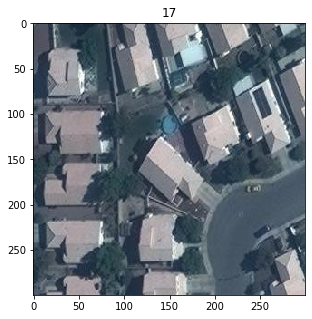

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os


BASE_PATH_DATA = '/content/drive/MyDrive/Удмуртия/train_dataset_train/train'
BASE_PATH_TEST = '/content/drive/MyDrive/Удмуртия/test_dataset_test/'

# choose random image
data_df = pd.read_csv(BASE_PATH_DATA + '.csv')
random_ind = np.random.randint(0, len(os.listdir(BASE_PATH_DATA)), 1)
image_name = data_df.loc[random_ind, 'img_num'].values[0]
image_path = f"{BASE_PATH_DATA}/{image_name}"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# imshow
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.set_title(data_df.loc[random_ind, 'number_of_houses'].values[0])
axes.imshow(Image.fromarray(image))

# save to inference
np.save('/content/rgb-footprint-extract/images/example.npy', image)

## Запускаем обучение

In [ ]:
cd /content/rgb-footprint-extract

/content/rgb-footprint-extract


In [ ]:
%%bash 

#pip uninstall pycocotools
#pip install --upgrade numpy
#pip install pycocotools --no-binary pycocotools

Found existing installation: pycocotools 2.0.0
Uninstalling pycocotools-2.0.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pycocotools-2.0.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pycocotools/*
Proceed (y/n)? Your response ('#pip install --upgrade numpy') was not one of the expected responses: y, n
Proceed (y/n)? Your response ('#pip install pycocotools --no-binary pycocotools') was not one of the expected responses: y, n
Proceed (y/n)? 

ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/uninstall.py", line 86, in run
    auto_confirm=options.yes, verbose=self.verbosity > 0,
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_install.py", line 658, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_uninstall.py", line 380, in remove
    if auto_confirm or self._allowed_to_proceed(verbose):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_uninstall.py", line 423, in _allowed_to_proceed
    return ask('Proceed (y/n)? ', ('y', 'n')) == 'y'
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/utils/misc.py", line 203, in ask
    response = input(message)
EOFError: EOF when reading a line


### Переводим в нужный формат

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import os
from tqdm import tqdm

class COCOAnnotationToMask:
    """
        Directory should be in the structure:
        root_dir/
            annotations.json
            /images
                ... list of images from dataset
            /masks (optional)
            
    """
    def __init__(self, root_dir):
        self.root_dir = root_dir
        ##### choose name
        self.coco_client = COCO(os.path.join(self.root_dir, 'annotation.json'))

        self.category_ids = self.coco_client.getCatIds(catNms=['building'])
        self.image_ids = self.coco_client.getImgIds(catIds=self.category_ids)

        self.save_dir = root_dir
        if 'masks' not in os.listdir(root_dir):
            os.mkdir(f"{root_dir}/masks")

    def convert(self):
        no_annotations = 0
        pbar = tqdm(self.image_ids)
        pbar.set_description("{} samples have no annotations".format(no_annotations))

        for img_id in pbar:
            meta = self.coco_client.loadImgs(ids=[img_id])[0]

            # image = io.imread(os.path.join(self.root_dir, "images", meta['file_name']))
            mask = self.generate_mask(meta)
            if mask is None:
                no_annotations += 1
                pbar.set_description("{} samples have no annotations".format(no_annotations))
                continue

            mask = mask.astype(np.uint8)
            np.save(os.path.join(self.save_dir, "masks", meta['file_name'] + "_mask"), mask)    
            
    def generate_mask(self, meta):
        annotation_ids = self.coco_client.getAnnIds(imgIds=meta['id'], catIds=self.category_ids)
        annotations = self.coco_client.loadAnns(annotation_ids)

        mask = np.zeros((meta['height'], meta['width']))
        for ann in annotations:
            mask[:, :] = np.maximum(mask[:, :], self.coco_client.annToMask(ann))

        if len(annotations) == 0:
            return None

        return mask


if __name__ == "__main__":
    """
    Example Usage:
        converter = COCOAnnotationToMask('/data/AICrowd/val')
        converter.convert()
    """
    converter = COCOAnnotationToMask('/content/rgb-footprint-extract/data/AICrowd/train')
    converter.convert()

    converter = COCOAnnotationToMask('/content/rgb-footprint-extract/data/AICrowd/val')
    converter.convert()

### При необходимости веса для лосса

In [ ]:
import os
import numpy as np
import torch
from torch.nn.functional import interpolate
from tqdm import tqdm
from skimage.segmentation import find_boundaries

class Processor():
    def __init__(self, root_path, w0, sigma, inc, resize=None, start=None):
        self.root_path = root_path
        self.masks_path = os.path.join(self.root_path, "masks")

        self.masks_wt_path = os.path.join(self.root_path, "masks_wt")
        if not os.path.exists(self.masks_wt_path):
            os.mkdir(self.masks_wt_path)
        

        self.w0, self.sigma = w0, sigma
        self.inc = inc
        self.resize = resize
        self.start = start

    def process(self,):
        pbar = tqdm(os.listdir(self.masks_path))
        if self.start is not None:
            print("Starting at {}".format(self.start))
            pbar = tqdm(list(os.listdir(self.masks_path))[self.start:])

        for mask_path in pbar:
            mask = np.load(os.path.join(self.masks_path, mask_path))
            mask = (mask > 0).astype(np.int32)

            if self.resize is not None:
                mask = self.resize_mask(mask).squeeze().astype(np.int32)

            mask_weight = np.expand_dims(mask, axis=0)
            endpoint = mask.shape[0]
            max_step = int(np.ceil(endpoint / self.inc))

            for i in range(max_step):
                si, ei = i*self.inc, min(endpoint, i*self.inc+self.inc)

                for j in range(max_step):
                    sj, ej = j*self.inc, min(endpoint, j*self.inc+self.inc)

                    if len(np.unique(mask[si:ei, sj:ej])) > 1:
                        mask_weight[:, si:ei, sj:ej] = self.make_weight_map(mask_weight[:, si:ei, sj:ej])
                    else:
                        mask_weight[:, si:ei, sj:ej] = 0

            np.save(
                os.path.join(self.masks_wt_path, mask_path.replace("_mask.npy", "_mask_wt.npy")),
                mask_weight.astype(np.uint8).squeeze()
            )

    def resize_mask(self, mask):
        return interpolate(torch.tensor(mask).unsqueeze(0).unsqueeze(0).float(), size=self.resize, mode="nearest").detach().numpy()

    def make_weight_map(self, masks):
        """
        Generate the weight maps as specified in the UNet paper
        for a set of binary masks.
        
        Parameters
        ----------
        masks: array-like
            A 3D array of shape (n_masks, image_height, image_width),
            where each slice of the matrix along the 0th axis represents one binary mask.
        Returns
        -------
        array-like
            A 2D array of shape (image_height, image_width)
        
        """
        nrows, ncols = masks.shape[1:]
        masks = (masks > 0).astype(int)
        distMap = np.zeros((nrows * ncols, masks.shape[0]))
        X1, Y1 = np.meshgrid(np.arange(nrows), np.arange(ncols))
        X1, Y1 = np.c_[X1.ravel(), Y1.ravel()].T
        for i, mask in enumerate(masks):
            # find the boundary of each mask,
            # compute the distance of each pixel from this boundary
            bounds = find_boundaries(mask, mode='inner')
            X2, Y2 = np.nonzero(bounds)
            xSum = (X2.reshape(-1, 1) - X1.reshape(1, -1)) ** 2
            ySum = (Y2.reshape(-1, 1) - Y1.reshape(1, -1)) ** 2
            distMap[:, i] = np.sqrt(xSum + ySum).min(axis=0)
        ix = np.arange(distMap.shape[0])
        if distMap.shape[1] == 1:
            d1 = distMap.ravel()
            border_loss_map = self.w0 * np.exp((-1 * (d1) ** 2) / (2 * (self.sigma ** 2)))
        else:
            if distMap.shape[1] == 2:
                d1_ix, d2_ix = np.argpartition(distMap, 1, axis=1)[:, :2].T
            else:
                d1_ix, d2_ix = np.argpartition(distMap, 2, axis=1)[:, :2].T
            d1 = distMap[ix, d1_ix]
            d2 = distMap[ix, d2_ix]
            border_loss_map = self.w0 * np.exp((-1 * (d1 + d2) ** 2) / (2 * (self.sigma ** 2)))
        xBLoss = np.zeros((nrows, ncols))
        xBLoss[X1, Y1] = border_loss_map
        # class weight map
        loss = np.zeros((nrows, ncols))
        w_1 = 1 - masks.sum() / loss.size
        w_0 = 1 - w_1
        loss[masks.sum(0) == 1] = w_1
        loss[masks.sum(0) == 0] = w_0
        ZZ = xBLoss + loss
        return ZZ

if __name__ == "__main__":
    """
    Example Usage:
        processor = Processor("/data/AICrowd/train/", 10, 7.5, 150)
        processor.process()
    """
    processor = Processor('/content/rgb-footprint-extract/data/AICrowd/train', 10, 7.5, 150)
    processor.process()

    processor = Processor('/content/rgb-footprint-extract/data/AICrowd/val', 10, 7.5, 150)
    processor.process()

In [ ]:
cd /content/rgb-footprint-extract/data/AICrowd/train

/content/rgb-footprint-extract/data/AICrowd/train


### Выставляем настройки и запускаем

In [ ]:
cd /content/rgb-footprint-extract/data/AICrowd/train/masks_wt

In [ ]:
from tqdm import tqdm 
import os 
import numpy as np

for file_ in os.listdir('/content/rgb-footprint-extract/data/AICrowd/train/images'):
  np.save(f'{file_}_mask_wt.npy', np.ones((300, 300)))

In [10]:
cd /content/rgb-footprint-extract

/content/rgb-footprint-extract


In [ ]:
%%bash

CUDA_VISIBLE_DEVICES=0 python3 run_deeplab.py --backbone=drn_c42 --out-stride=8 --dataset=crowdAI \
    --workers=4 --loss-type=wce_dice --fbeta=0.5 --epochs=60 --batch-size=4 --test-batch-size=4 --weight-decay=1e-4 \
    --gpu-ids=0 --lr=1e-3 --loss-weights 1.0 1.0 --dropout 0.3 0.5 --incl-bounds \
    --checkname=_urban3d_deeplab_drn_c42_wce_dicef0.5 --data-root=/content/rgb-footprint-extract/data/

## Запускаем инференс

In [20]:
%%bash

CUDA_VISIBLE_DEVICES=0 python3 run_deeplab.py --inference --backbone=drn_c42\
    --workers=2 --epochs=1 --test-batch-size=1 --gpu-ids=0 --resume=crowdAI --best-miou \
    --input-filename='images/example.npy' \
    --output-filename='results/output.png'

Testing on 1 samples
Using backbone drn_c42 with output stride 16 and dropout values 0.1, 0.5
Resuming from weights/crowdAI/best_miou_checkpoint.pth.tar
Inference starting on images/example.npy...


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


### Результаты на примере

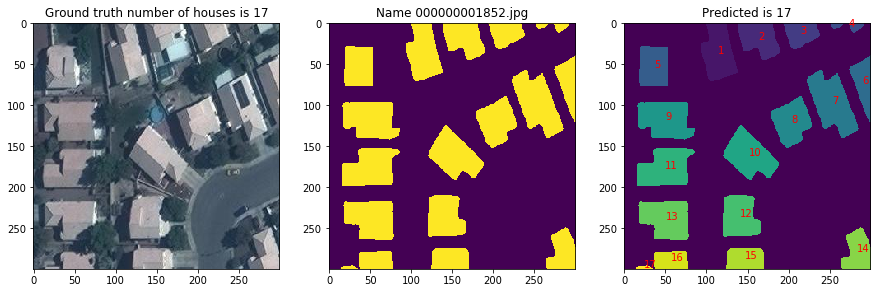

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 15))

_res = np.load('images/example.npy')
gt = data_df.loc[random_ind, 'number_of_houses'].values[0]

axes[0].set_title(f'Ground truth number of houses is {gt}')
axes[0].imshow(Image.fromarray(image))

_preds = np.array(Image.open('results/output.png'))
_output = cv2.connectedComponentsWithStats(_preds, 4, cv2.CV_32S)

axes[1].set_title(f'Name {image_name}')
axes[1].imshow(Image.open('results/output.png'))

axes[2].set_title(f'Predicted is {_output[0] - 1}')
axes[2].imshow(_output[1])

axes[2].imshow(_output[1])
for i, center in enumerate(_output[3]):
  if i > 0:
    axes[2].text(center[0], center[1], f'{i}', color='red')

### Сохраняем картинки в нужную папку

In [ ]:
BASE_PATH_DATA = '/content/drive/MyDrive/Удмуртия/test_dataset_test/'

for image_name in os.listdir('/content/drive/MyDrive/Удмуртия/test_dataset_test/'):
  image_path = f"{BASE_PATH_DATA}/{image_name}"
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  np.save(f'/content/drive/MyDrive/Удмуртия/test/{image_name[:-4]}.npy', image)

### Получаем сегментационные маски на всех тестовых картинках

In [ ]:
cd /content/rgb-footprint-extract/

/content/rgb-footprint-extract


In [ ]:
%%bash
echo "Bash version ${BASH_VERSION}..."

for file in /content/drive/MyDrive/Удмуртия/test_dataset_test/*
do
  full="${file}"
  name=${full:50:12}
  echo "${name}"
  input="/content/drive/MyDrive/Удмуртия/test/${name}.npy"
  output="/content/drive/MyDrive/Удмуртия/best_results/${name}.png"
  #echo "${input}"
  #echo "${output}"
  CUDA_VISIBLE_DEVICES=0 python3 run_deeplab.py --inference --backbone=drn_c42 \
    --workers=2 --epochs=1 --test-batch-size=1 --gpu-ids=0 --resume=crowdAI --best-miou \
    --input-filename="${input}" \
    --output-filename="${output}"
done

In [ ]:
BASE_PATH_DATA_2 = '/content/drive/MyDrive/Удмуртия/train_dataset_train/'
BASE_PATH_TEST = '/content/drive/MyDrive/Удмуртия/test_dataset_test/'
BASE_PATH_RESULT = '/content/drive/MyDrive/Удмуртия/best_results'

subm = pd.read_csv(BASE_PATH_DATA_2 + 'sample_solution.csv')

#### Подгружаем пример сабмита

In [ ]:
subm.head()

,img_num,number_of_houses
0,000000001801.jpg,1
1,000000001190.jpg,1
2,000000001817.jpg,1
3,000000000251.jpg,1
4,000000002505.jpg,1


#### Считаем количество домов

In [ ]:
from tqdm import tqdm
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

_numbers = []
names = []
BASE_PATH_RESULT = '/content/drive/MyDrive/Удмуртия/best_results'

for img_name_res in tqdm(os.listdir(BASE_PATH_RESULT)):
  names.append(img_name_res)
  image_path_res = f"{BASE_PATH_RESULT}/{img_name_res}"
  img_res = np.array(Image.open(image_path_res))
  output = cv2.connectedComponentsWithStats(img_res, 4, cv2.CV_32S)
  _numbers.append(output[0] - 1)

100%|██████████| 900/900 [00:02<00:00, 421.96it/s]


In [ ]:
d = {}

for name, value in zip(names, _numbers):
  d[name[:-4] + '.jpg'] = value

subm['number_of_houses'] = subm['img_num'].apply(lambda x: d[x])

#### Сохраняем и сабмитим

In [ ]:
subm

,img_num,number_of_houses
0,000000001801.jpg,7
1,000000001190.jpg,1
2,000000001817.jpg,13
3,000000000251.jpg,17
4,000000002505.jpg,6
...,...,...
895,000000002443.jpg,8
896,000000000856.jpg,6
897,000000001983.jpg,5
898,000000000166.jpg,2


In [ ]:
#subm.to_csv('/content/drive/MyDrive/Удмуртия/second.csv', index=False)